In [72]:
import os
import pandas as pd
import csv
import numpy as np

FIGSIZE = (20, 6)

In [73]:
file_dir = "inmet-data"
years = [i.name for i in os.scandir(f"{file_dir}") if i.is_dir()]
filenames = []
for y in years:
    filenames.extend(
        [f"{file_dir}/{y}/{f.name}" for f in os.scandir(f"{file_dir}/{y}")]
    )

len(filenames)

9460

In [74]:
cols = [
    "year",
    "region",
    "state",
    "station-name",
    "code",
    "lat",
    "lon",
    "height",
    "starts_on",
]

In [75]:
df = pd.DataFrame(columns=cols)

for i, f in enumerate(filenames):
    file = open(f, "r", encoding="iso-8859-1")
    data = [f.split("/")[1]]
    for i in range(8):
        line = file.readline()
        data.append(line.split(";")[1][:-1])
    df.loc[len(df.index)] = dict(zip(cols, data))

df

,year,region,state,station-name,code,lat,lon,height,starts_on
0,2019,CO,MS,LAGUNA CARAPA,S711,"-22,575389","-55,160333",499,12/04/18
1,2019,NE,BA,AMARGOSA,A434,"-13,009468","-39,616881","397,8",11/07/08
2,2019,N,AP,MACAPA,A249,",03502","-51,088763","16,62",12/12/13
3,2019,SE,MG,PATOS DE MINAS,A562,"-18,520667","-46,440611",950,12/05/17
4,2019,N,AP,PORTO GRANDE,A244,",69444444","-51,40416666",84,17/09/08
...,...,...,...,...,...,...,...,...,...
9455,2004,NE,RN,NATAL,A304,"-5,9","-35,2","48,6",2003-02-24
9456,2004,SE,MG,ARAXA,A505,"-19,60555555","-46,94944444",1020,2002-12-19
9457,2004,S,RS,PORTO ALEGRE,A801,"-30,05","-51,16666666","46,97",2000-09-22
9458,2004,SE,MG,ALMENARA,A508,"-16,16666666","-40,68777777",194,2002-12-15


In [76]:
df["lat"] = df["lat"].apply(lambda n: np.float64(n.replace(",", ".")))
df["lon"] = df["lon"].apply(lambda n: np.float64(n.replace(",", ".")))
df

,year,region,state,station-name,code,lat,lon,height,starts_on
0,2019,CO,MS,LAGUNA CARAPA,S711,-22.575389,-55.160333,499,12/04/18
1,2019,NE,BA,AMARGOSA,A434,-13.009468,-39.616881,"397,8",11/07/08
2,2019,N,AP,MACAPA,A249,0.035020,-51.088763,"16,62",12/12/13
3,2019,SE,MG,PATOS DE MINAS,A562,-18.520667,-46.440611,950,12/05/17
4,2019,N,AP,PORTO GRANDE,A244,0.694444,-51.404167,84,17/09/08
...,...,...,...,...,...,...,...,...,...
9455,2004,NE,RN,NATAL,A304,-5.900000,-35.200000,"48,6",2003-02-24
9456,2004,SE,MG,ARAXA,A505,-19.605556,-46.949444,1020,2002-12-19
9457,2004,S,RS,PORTO ALEGRE,A801,-30.050000,-51.166667,"46,97",2000-09-22
9458,2004,SE,MG,ALMENARA,A508,-16.166667,-40.687778,194,2002-12-15


In [77]:
def calculate_distance_from_geolocation(lat_a, lon_a, lat_b, lon_b):
    R = np.float(6371)  # Radius of the Earth in kilometers

    lat_a = np.radians(lat_a)
    lon_a = np.radians(lon_a)
    lat_b = np.radians(lat_b)
    lon_b = np.radians(lon_b)

    dlat = lat_b - lat_a
    dlon = lon_b - lon_a

    # Apply the Haversine formula
    a = np.sin(dlat / 2) ** 2 + np.cos(lat_a) * np.cos(lat_b) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c

    return c


def in_code_radius(df: pd.DataFrame, code: str, radius) -> pd.DataFrame:
    lat, lon = df.loc[df.code == code, ["lat", "lon"]].iloc[0]
    print(type(lat))
    return df.loc[
        calculate_distance_from_geolocation(lat, lon, df.lat, df.lon) < radius
    ]


in_radius = in_code_radius(df, "A627", 40)
in_radius_dict = {
    i: in_radius.loc[in_radius.code == "A627", "year"].unique()
    for i in in_radius["code"].unique()
}

in_radius_dict

<class 'float'>


{'A621': array(['2019', '2022', '2021', '2023', '2024', '2020', '2018'],
       dtype=object),
 'A627': array(['2019', '2022', '2021', '2023', '2024', '2020', '2018'],
       dtype=object),
 'A652': array(['2019', '2022', '2021', '2023', '2024', '2020', '2018'],
       dtype=object),
 'A636': array(['2019', '2022', '2021', '2023', '2024', '2020', '2018'],
       dtype=object),
 'A603': array(['2019', '2022', '2021', '2023', '2024', '2020', '2018'],
       dtype=object)}

In [42]:
from src.read_input import group_datasets_by_location, format_dataset
from src.grouping_data import group_df_by_day

dfs = {}
for code in in_radius_dict:
    formatted = format_dataset(group_datasets_by_location(code, in_radius_dict[code]))
    dfs[code] = group_df_by_day(formatted)

In [43]:
from src.forecasting.forecast_picker import ForecastPicker
from src.utils import DEFAULT_TARGET_COLUMN, DEFAULT_INDEX_COLUMN
from sklearn.metrics import mean_absolute_percentage_error

target = DEFAULT_TARGET_COLUMN
idx = DEFAULT_INDEX_COLUMN

date_threshold = pd.to_datetime("2023", format="%Y")
date_upper = date_threshold + pd.DateOffset(months=6)

fps = {
    k: ForecastPicker(
        df, date_threshold, date_upper, target, idx, mean_absolute_percentage_error
    )
    for k, df in dfs.items()
}

[0]	validation_0-rmse:649.83912	validation_1-rmse:702.32660
[99]	validation_0-rmse:148.10146	validation_1-rmse:249.64023


12:31:50 - cmdstanpy - INFO - Chain [1] start processing
12:31:50 - cmdstanpy - INFO - Chain [1] done processing


[0]	validation_0-rmse:1138.05669	validation_1-rmse:1295.43617
[99]	validation_0-rmse:179.08807	validation_1-rmse:550.47329


12:31:51 - cmdstanpy - INFO - Chain [1] start processing
12:31:51 - cmdstanpy - INFO - Chain [1] done processing


[0]	validation_0-rmse:1252.65849	validation_1-rmse:1318.01007
[99]	validation_0-rmse:273.64682	validation_1-rmse:399.41457


12:31:51 - cmdstanpy - INFO - Chain [1] start processing
12:31:51 - cmdstanpy - INFO - Chain [1] done processing


[0]	validation_0-rmse:1107.66725	validation_1-rmse:1234.65168
[99]	validation_0-rmse:279.54021	validation_1-rmse:499.05159


12:31:52 - cmdstanpy - INFO - Chain [1] start processing
12:31:52 - cmdstanpy - INFO - Chain [1] done processing


[0]	validation_0-rmse:630.87993	validation_1-rmse:666.19255
[99]	validation_0-rmse:146.14229	validation_1-rmse:237.18782


12:31:52 - cmdstanpy - INFO - Chain [1] start processing
12:31:52 - cmdstanpy - INFO - Chain [1] done processing


{'A621': <src.forecasting.forecast_picker.ForecastPicker at 0x7f8add005de0>,
 'A627': <src.forecasting.forecast_picker.ForecastPicker at 0x7f8af5e080a0>,
 'A652': <src.forecasting.forecast_picker.ForecastPicker at 0x7f8add006590>,
 'A636': <src.forecasting.forecast_picker.ForecastPicker at 0x7f8af5f1e170>,
 'A603': <src.forecasting.forecast_picker.ForecastPicker at 0x7f8af6020910>}

In [45]:
len(fps)

5

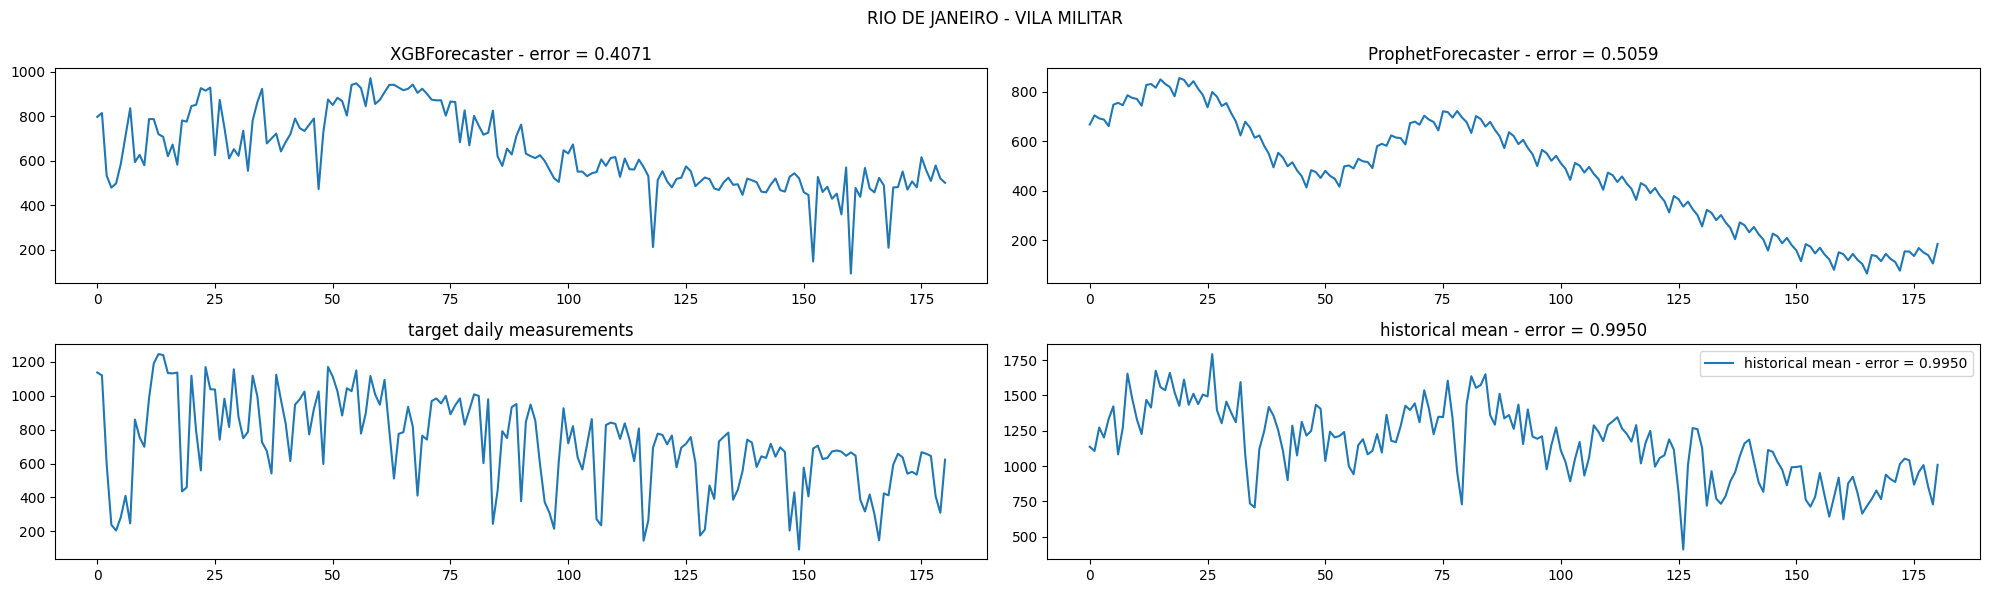

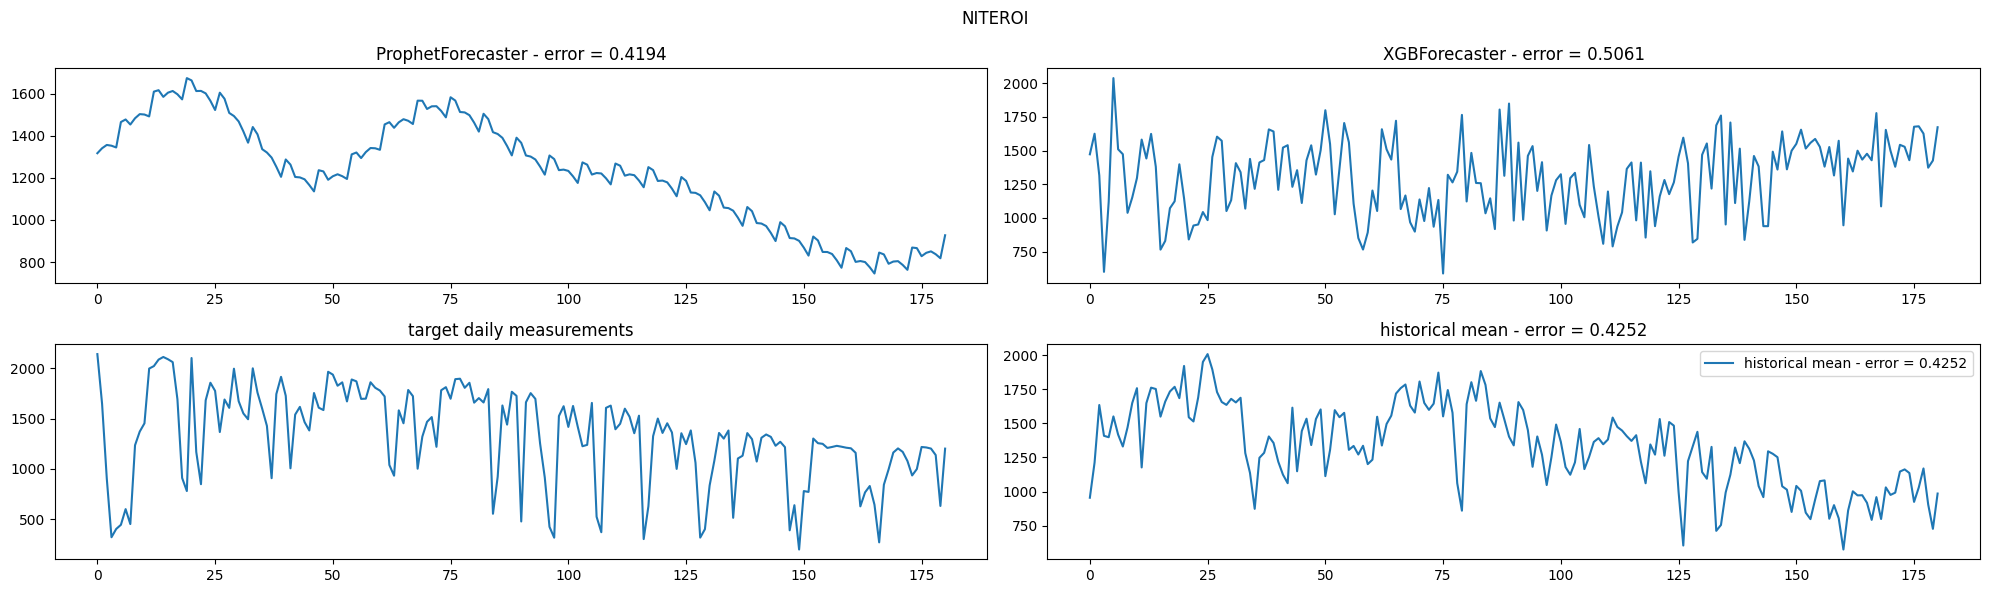

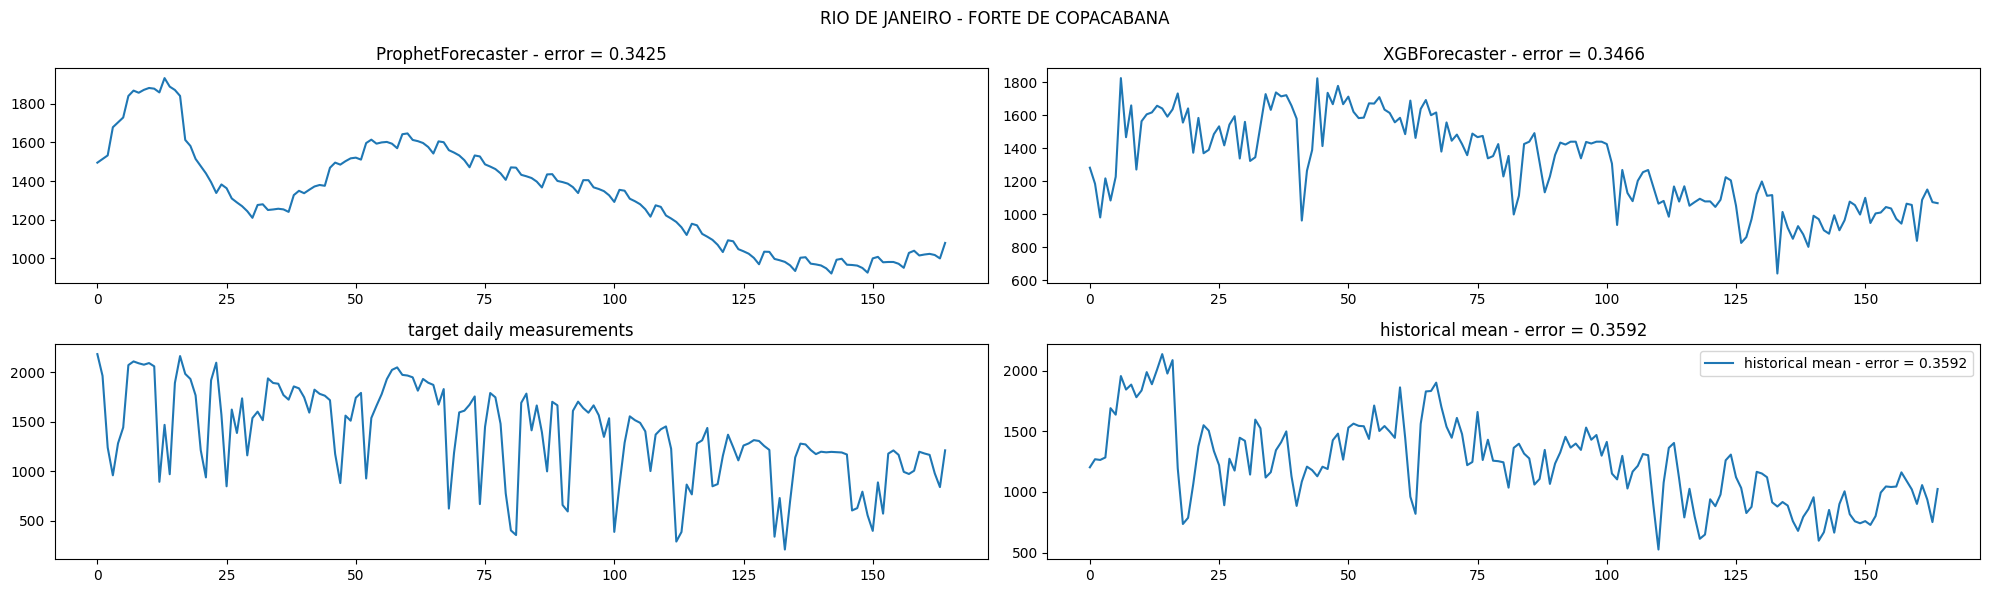

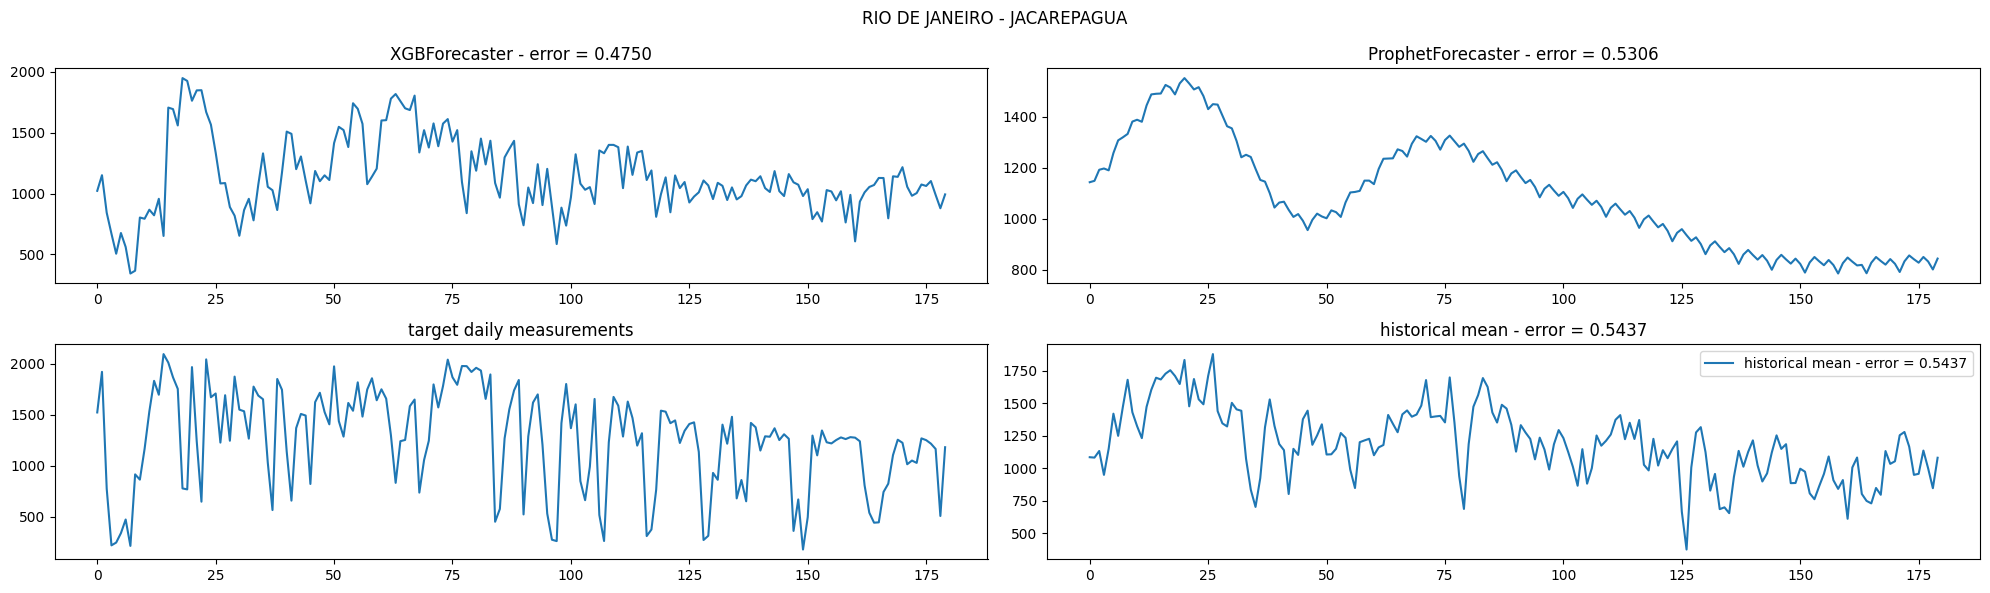

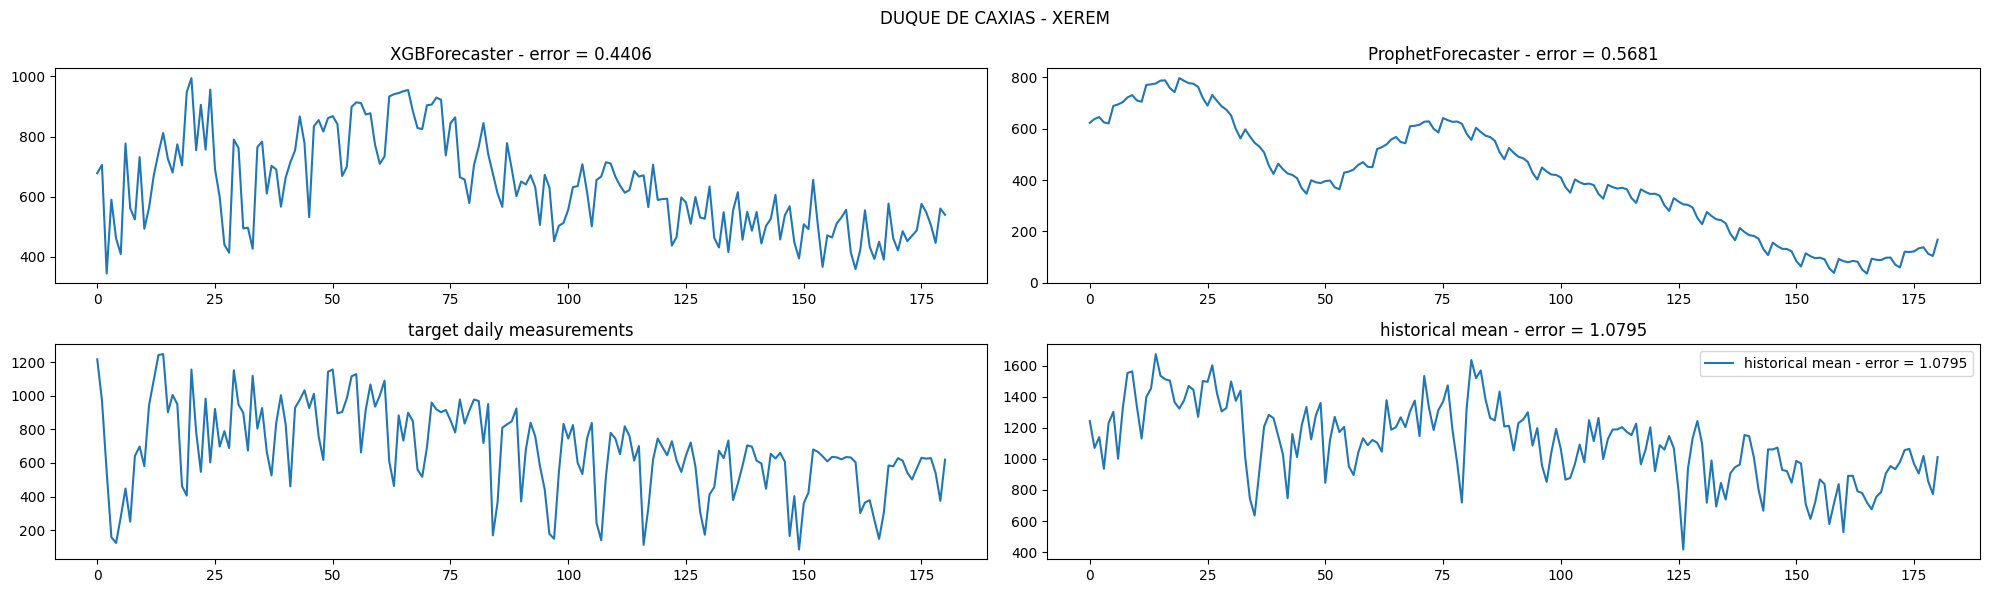

In [62]:
from matplotlib import pyplot as plt


for code, fp in fps.items():
    fig, axes = plt.subplots(2, 2)
    fig.set_figwidth(FIGSIZE[0])
    fig.set_figheight(FIGSIZE[1])
    fig.tight_layout()
    station_name = in_radius.loc[in_radius.code == code, "station-name"].iloc[0]
    fig.suptitle(station_name)
    df = fp.compare_predictions()
    for i, c in enumerate(df.columns):
        ax = axes[i % 2, int(i / 2)]
        ax.set_title(c)
        df[c].plot(ax=ax, label=c)
    plt.legend()
    plt.tight_layout()

In [63]:
from typing import Dict

prediction_start = pd.to_datetime("2024-06-01", format="%Y-%m-%d")

predictions: Dict[str, pd.DataFrame] = {
    code: fp.make_prediction(prediction_start) for code, fp in fps.items()
}
predictions

[0]	validation_0-rmse:1022.42081	validation_1-rmse:1022.42081
[99]	validation_0-rmse:360.89191	validation_1-rmse:360.89191


12:36:25 - cmdstanpy - INFO - Chain [1] start processing
12:36:25 - cmdstanpy - INFO - Chain [1] done processing
12:36:26 - cmdstanpy - INFO - Chain [1] start processing
12:36:26 - cmdstanpy - INFO - Chain [1] done processing


[0]	validation_0-rmse:1170.00996	validation_1-rmse:1170.00996
[99]	validation_0-rmse:449.59915	validation_1-rmse:449.59915
[0]	validation_0-rmse:998.89595	validation_1-rmse:998.89595
[99]	validation_0-rmse:371.32114	validation_1-rmse:371.32114


{'A621':             prediction
 2024-07-31  655.419617
 2024-08-01  740.860596
 2024-08-02  751.339050
 2024-08-03  712.084412
 2024-08-04  621.768066
 ...                ...
 2025-01-27  903.112732
 2025-01-28  838.120239
 2025-01-29  841.103821
 2025-01-30  814.175659
 2025-01-31  826.800537
 
 [185 rows x 1 columns],
 'A627':              prediction
 datetime               
 2024-06-02   895.630022
 2024-06-03   878.631048
 2024-06-04   876.383633
 2024-06-05   855.780991
 2024-06-06   868.037797
 ...                 ...
 2024-11-26  1282.694226
 2024-11-27  1276.051617
 2024-11-28  1301.568760
 2024-11-29  1266.039281
 2024-11-30  1346.969050
 
 [182 rows x 1 columns],
 'A652':              prediction
 datetime               
 2024-06-02  1033.369211
 2024-06-03  1028.051648
 2024-06-04  1030.080485
 2024-06-05  1006.971173
 2024-06-06   999.657253
 ...                 ...
 2024-11-26  1537.009118
 2024-11-27  1533.946823
 2024-11-28  1546.097902
 2024-11-29  1521.602493
 2024-11-

RIO DE JANEIRO - VILA MILITAR
NITEROI
RIO DE JANEIRO - FORTE DE COPACABANA
RIO DE JANEIRO - JACAREPAGUA
DUQUE DE CAXIAS - XEREM


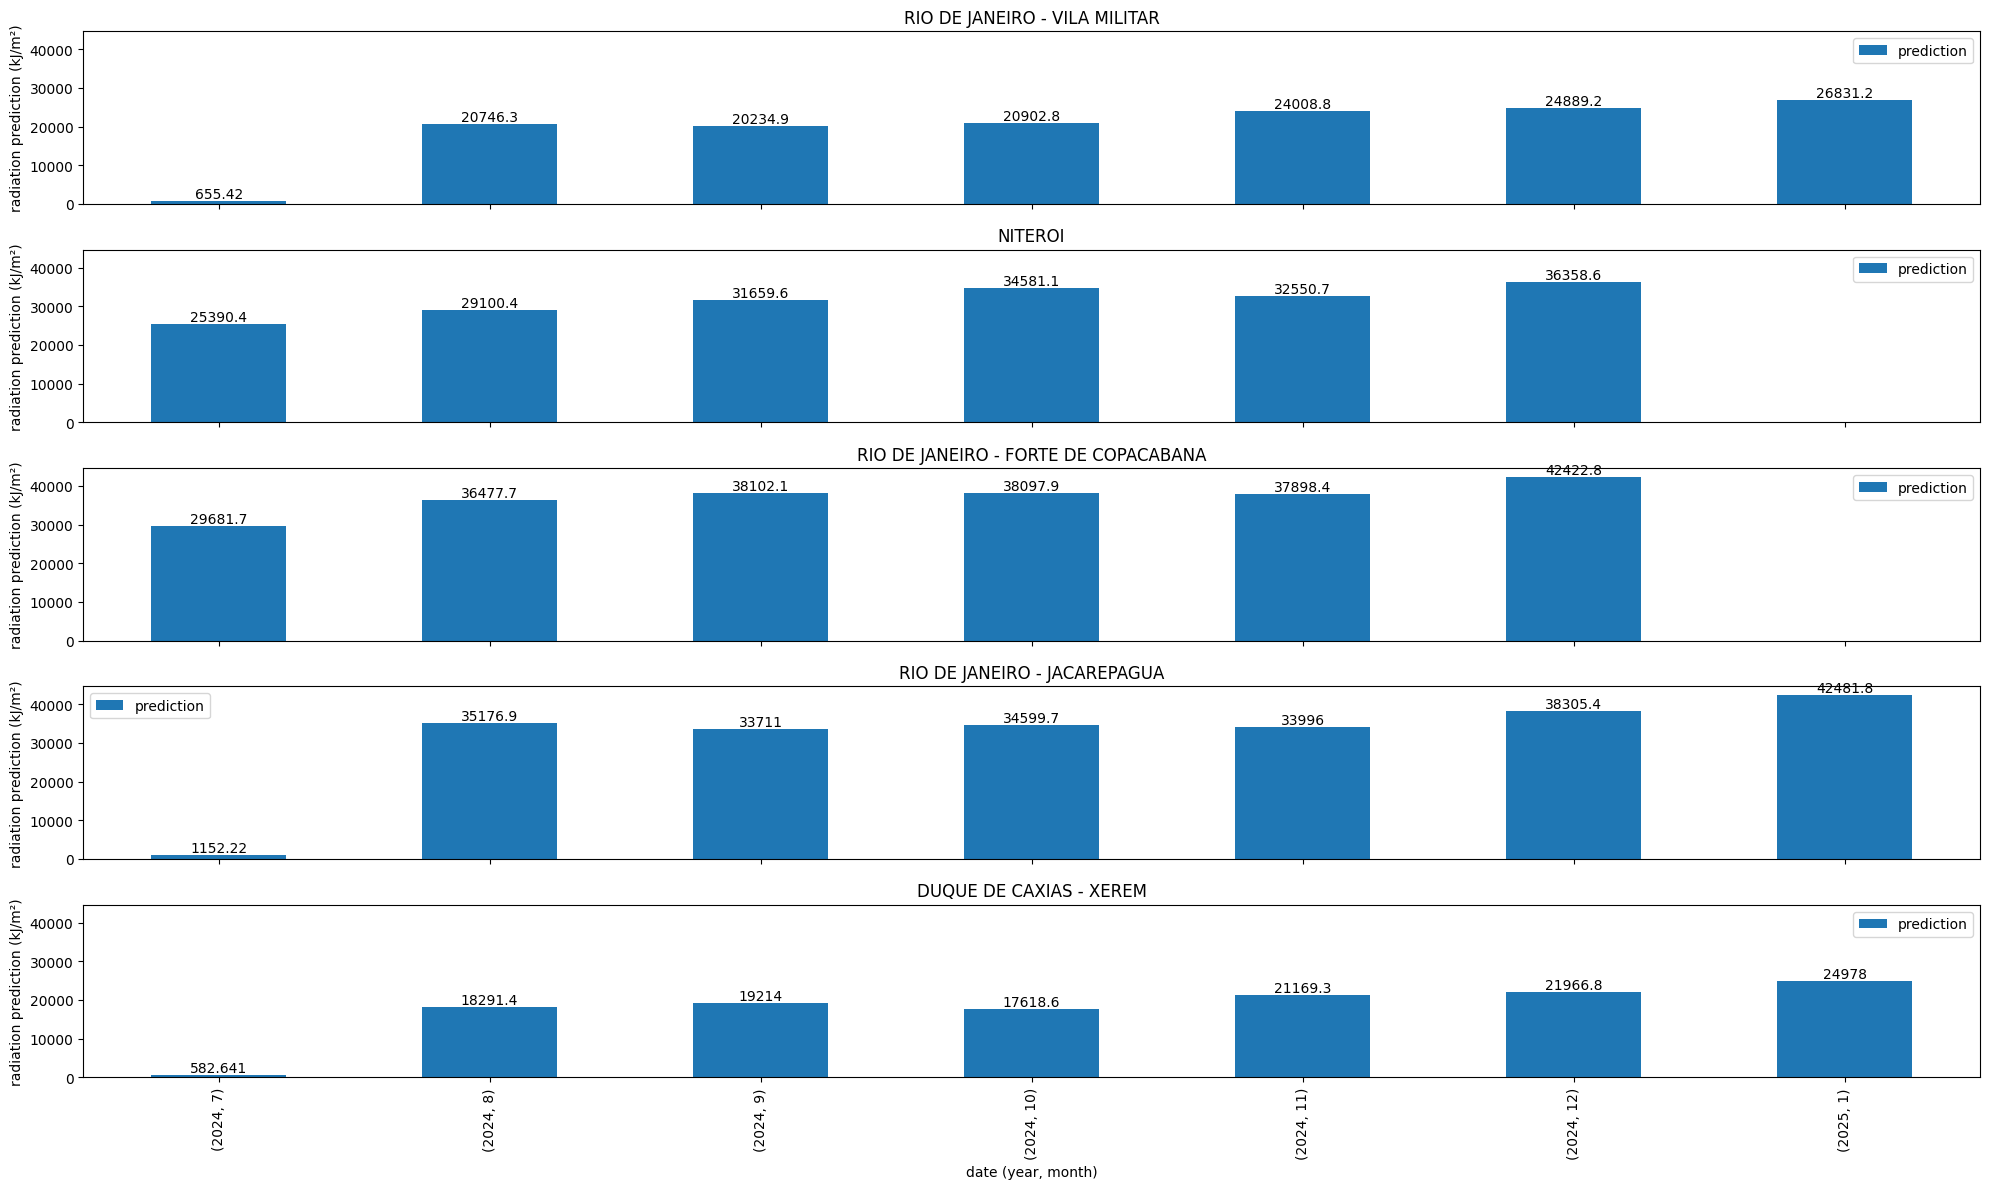

In [69]:
fig, axes = plt.subplots(len(predictions), sharex=True, sharey=True)
fig.set_figwidth(FIGSIZE[0])
fig.set_figheight(2 * FIGSIZE[1])

for i, (code, p) in enumerate(predictions.items()):
    station_name = in_radius.loc[in_radius.code == code, "station-name"].iloc[0]
    print(station_name)
    axes[i].set_title(station_name)
    by_month = p.groupby([p.index.year, p.index.month]).sum()
    ax = by_month.plot.bar(
        ax=axes[i], xlabel="date (year, month)", ylabel="radiation prediction (kJ/m²)"
    )
    for c in ax.containers:
        ax.bar_label(c)
    ax
plt.tight_layout()